In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint as pprint
import pickle as pickle
import scipy.stats as sts

In [4]:
files = ['AAPL', 'C', 'GBX', 'SPY', 'THO']
file_objs = []

for file in files:
    with open('data/' + file, 'rb') as pickle_file:
        file_objs.append(pickle.load(open('data/' + file, 'rb')))


In [91]:
file_objs[3][2][0]

34380

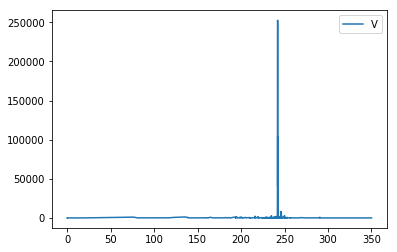

In [58]:
df = pd.DataFrame.from_dict(file_objs[3][2][1], orient='index')
df.head()
df.columns = ['V','Type','un1','un2']
df = df[['V','Type']]
df.sort_index(inplace=True, ascending=True)
demand = df[df.Type=='B']
supply = df[df.Type=='S']
df=df[df.index<1000]
df.plot()

In [80]:
class OrderBook():
    def __init__(self, orderBook, window, info):
        self.lower,self.upper = window
        self.time, self.ticker=info
        self.ob = pd.DataFrame.from_dict(orderBook, orient='index')
        self.ob.columns = ['V','Type','un1','un2']
        self.ob = self.ob[['V','Type']]
        self.demand = self.ob[self.ob['Type'] == 'B'].sort_index(ascending=False)
        self.supply = self.ob[self.ob['Type'] == 'S'].sort_index()
        self.demand['qd'] = -self.demand.V.cumsum()
        self.supply['qs'] = self.supply.V.cumsum()
        orders = pd.concat([self.demand, self.supply])
        orders = orders.fillna(0)
        orders['qt'] = orders['qd'] + orders['qs']
        self.midpoint = orders[orders.qt < 0].index.values[0]
        
        self.orders = orders[(orders.index > self.lower * self.midpoint) 
                             & (orders.index < self.upper * self.midpoint)]
        
        self.Q = self.orders.qt
        self.P = self.orders.index.values
        
    def estimate(self):
        slope, intercept, r_value, p_value, std_err = sts.linregress(self.P, self.Q)
        self.gamma = intercept
        self.beta = slope
        self.p = - self.gamma/self.beta
        self.ratio = self.beta    

    def plot(self):
        fig = plt.figure(figsize=(10,7))
        plt.plot(self.demand.index.values, self.demand.qd, label='Quantity Demanded')
        plt.plot(self.supply.index.values, self.supply.qs, label='Quantity Supplied')
        p_grid = np.linspace(self.lower * self.midpoint, self.upper * self.midpoint)
        plt.plot(p_grid, self.gamma + self.beta * p_grid, 'r', label='Estimated Equation')
        plt.xlim(0.5 * self.midpoint, 1.5 * self.midpoint)
        plt.xlabel('Price')
        plt.ylabel('Quantity')
        plt.title(self.ticker + ' Stock at t = %i' %self.time)
        plt.legend()
        plt.show()
        
    def compare(self):
        print("The estimated p_0 is: %f" %self.p)
        print("The actual midpoint of the BBO is: %f" %self.midpoint)

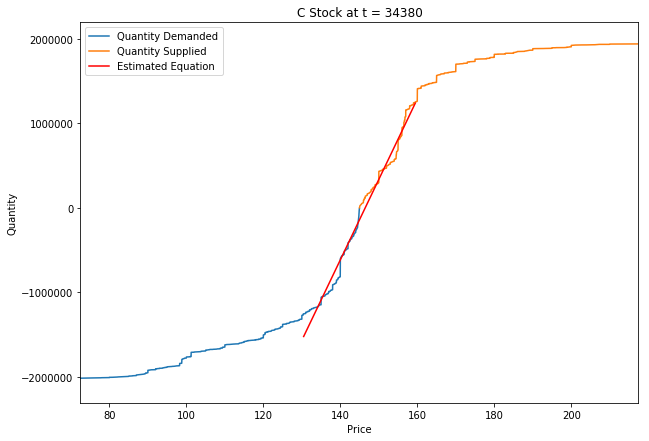

In [83]:
ob_test = OrderBook(file_objs[0][2][1],(.9, 1.1),(file_objs[0][2][0],files[1]))
ob_test.estimate()
ob_test.plot()

The model fits well for AAPL.

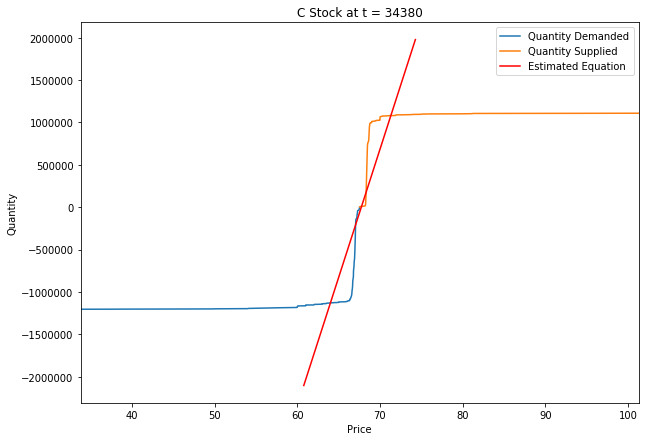

In [85]:
ob_test = OrderBook(file_objs[1][2][1],(.9, 1.1),(file_objs[1][2][0],files[1]))
ob_test.estimate()
ob_test.plot()

The cell doesn't fit well for C.

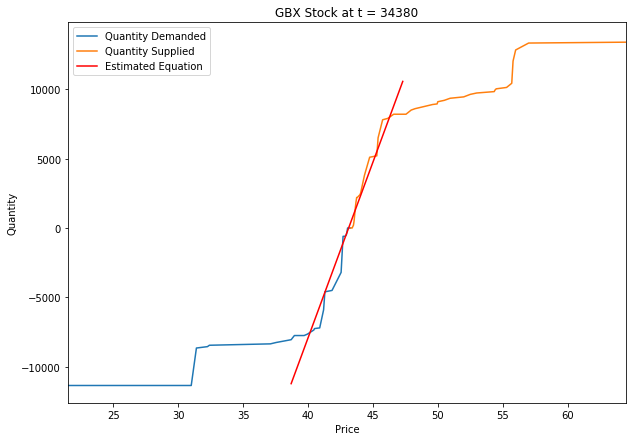

In [87]:
ob_test = OrderBook(file_objs[2][2][1],(.9, 1.1),(file_objs[2][2][0],files[2]))
ob_test.estimate()
ob_test.plot()

The model fits well for GBX

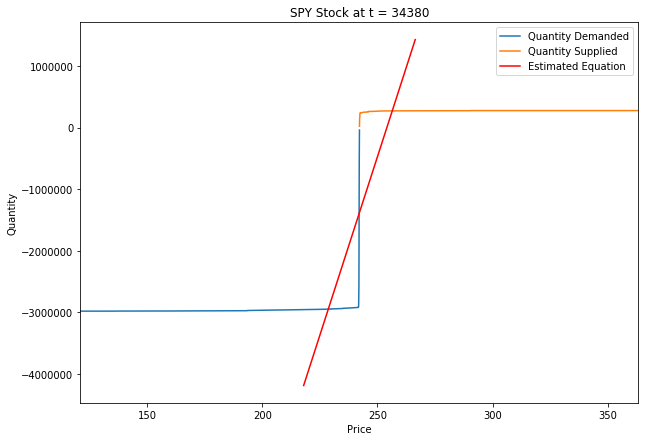

In [88]:
ob_test = OrderBook(file_objs[3][2][1],(.9, 1.1),(file_objs[3][2][0],files[3]))
ob_test.estimate()
ob_test.plot()

The model doesn't fit well for SPY.

Problem 2

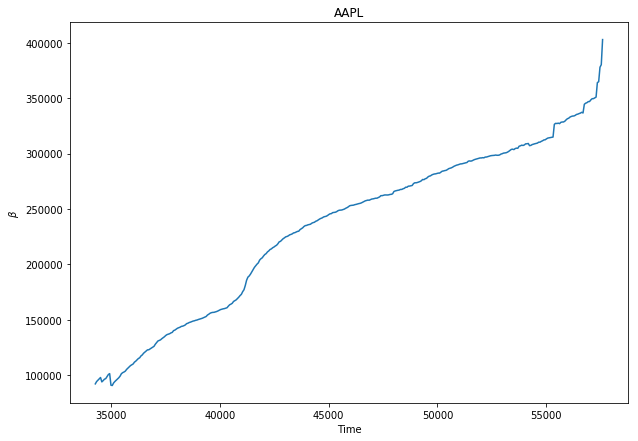

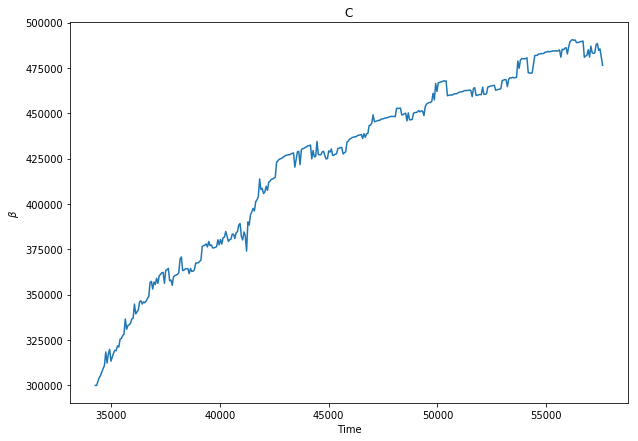

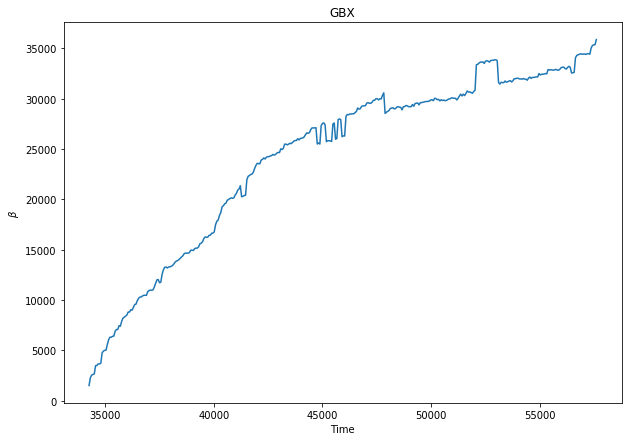

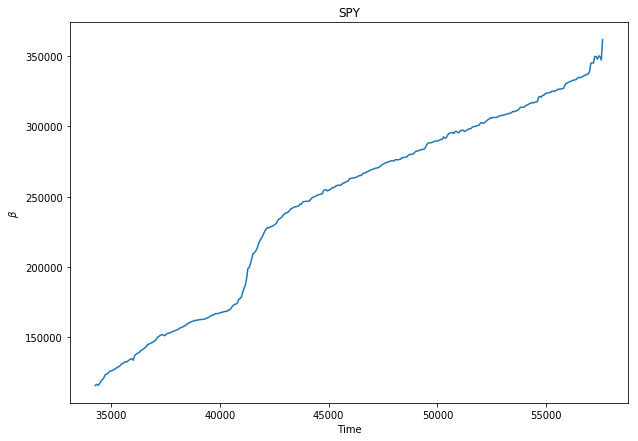

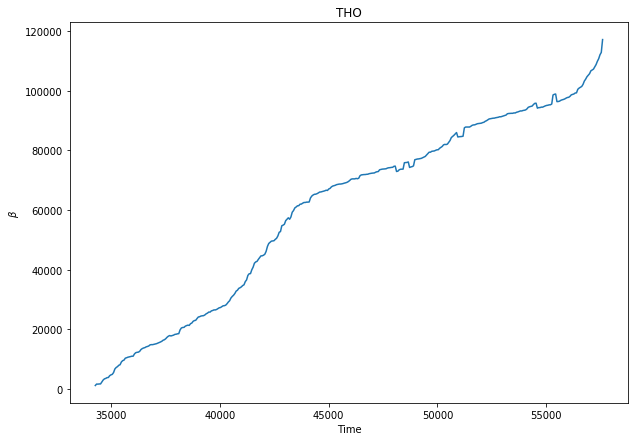

In [96]:
import datetime

for (i, name) in enumerate(files):
    times=[]
    betas =[]
    for (timestamp, orderbook) in file_objs[i]:
        times.append(timestamp)
        ob = OrderBook(orderbook, (.9, 1.1), (timestamp, name))
        ob.estimate()
        betas.append(ob.ratio)
    fig = plt.figure(figsize=(10,7))
    plt.plot(times, betas)
    plt.title(name)
    plt.xlabel('Time')
    plt.ylabel(r'$\beta_est$')
    plt.show()

Problem 3

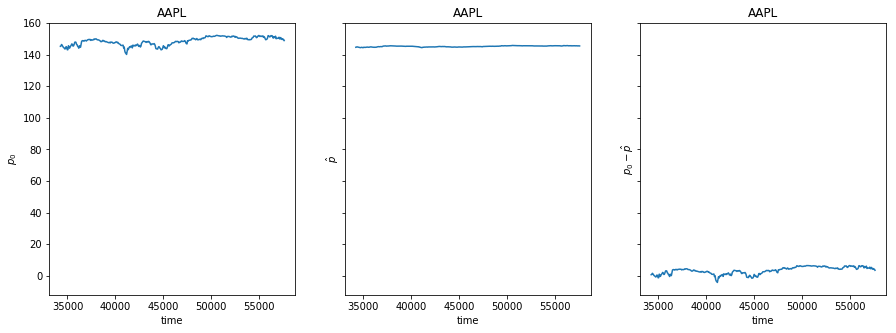

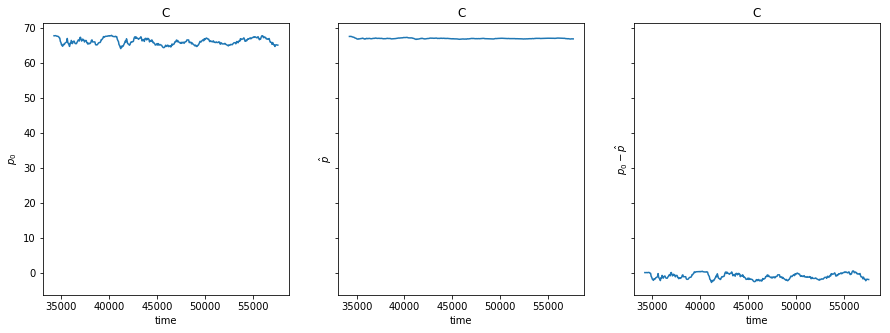

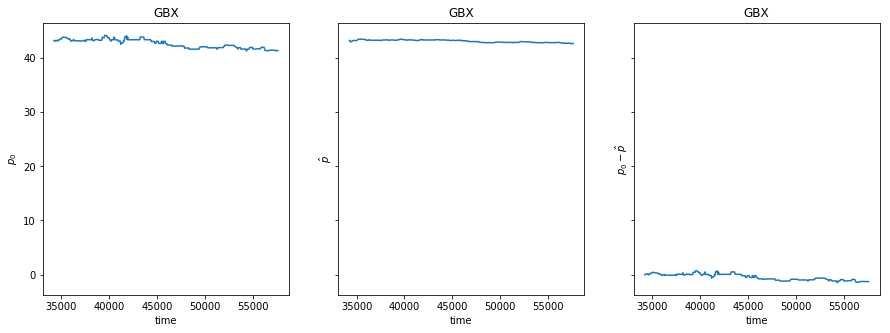

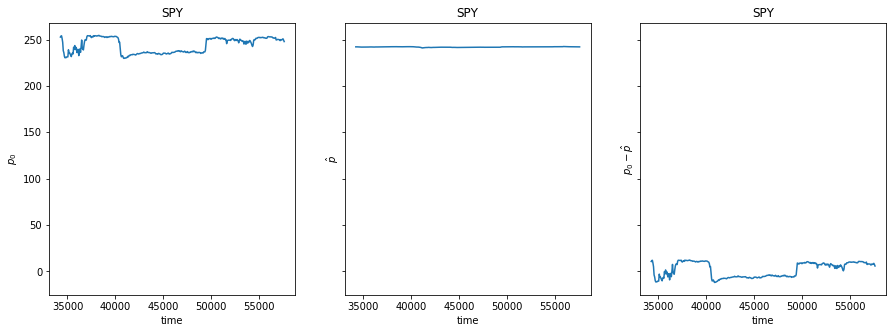

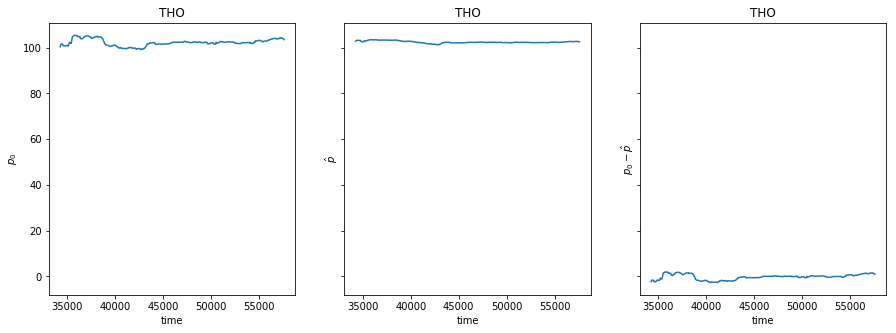

In [101]:
for (i, name) in enumerate(files):
    times=[]
    p_0 =[]
    p_mid=[]
    diff=[]
    for (timestamp, orderbook) in file_objs[i]:
        times.append(timestamp)
        ob = OrderBook(orderbook, (.9, 1.1), (timestamp, name))
        ob.estimate()
        p_0.append(ob.p)
        p_mid.append(ob.midpoint)
        diff.append(ob.p-ob.midpoint)
    f, (ax1, ax2, ax3)=plt.subplots(1,3,sharey=True)
#     fig = plt.figure(figsize=(10,7))
    f.set_figheight(5)
    f.set_figwidth(15)
    ax1.plot(times, p_0)
    ax1.set_ylabel(r'$p_0$')
    ax1.set_xlabel('time')
    ax1.set_title(name)
    ax2.plot(times, p_mid)
    ax2.set_ylabel(r'$\hat{p}$')
    ax2.set_xlabel('time')
    ax2.set_title(name)
    ax3.plot(times, diff)
    ax3.set_ylabel(r'$p_0-\hat{p}$')
    ax3.set_xlabel('time')
    ax3.set_title(name)
    plt.show()